In [7]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [8]:
from mimetypes import init
from pyexpat import model
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Lambda
from torchvision import transforms
from torch.nn import CrossEntropyLoss, BCEWithLogitsLoss

import matplotlib.pyplot as plt
import random
import pdb
import argparse


class MNISTDatasetWithConcepts(Dataset):
	def __init__(self,split,num_classes,transform):
		isTrain = False
		if split == "train":
			isTrain=True
		self.device = "cuda" if torch.cuda.is_available() else "cpu"
		self.data = MNIST(root = "./synthetic_datasets",train=isTrain, download=True)
		self.num_classes = num_classes
		self.transform = transform
		# print(len(set([self.data[i][1] for i in range(len(self.data))])))

	def __len__(self):
		return len(self.data)

	def __getitem__(self,idx):
		img,label = self.data[idx][0],self.data[idx][1]
		onehot = torch.zeros((self.num_classes,))
		onehot[label] =1
		concept = self.make_concepts_mnist(label)
		label = onehot.to(self.device)
		return [self.transform(img).to(self.device),label,concept]

	def make_concepts_mnist(self,label):
		if label == 0:
			hard_label = torch.tensor([1,0,0,0,0,0,0,0,0,0]+[1,0])
		elif label == 1:
			hard_label = torch.tensor([0,1,0,0,0,0,0,0,0,0]+[0,1])
		elif label == 2:
			hard_label = torch.tensor([0,0,1,0,0,0,0,0,0,0]+[1,1])
		elif label == 3:
			hard_label = torch.tensor([0,0,0,1,0,0,0,0,0,0]+[1,0])
		elif label == 4:
			hard_label = torch.tensor([0,0,0,0,1,0,0,0,0,0]+[0,1])
		elif label == 5:
			hard_label = torch.tensor([0,0,0,0,0,1,0,0,0,0]+[1,1])
		elif label == 6:
			hard_label = torch.tensor([0,0,0,0,0,0,1,0,0,0]+[1,0])
		elif label == 7:
			hard_label = torch.tensor([0,0,0,0,0,0,0,1,0,0]+[0,1])
		elif label == 8:
			hard_label = torch.tensor([0,0,0,0,0,0,0,0,1,0]+[1,0])
		elif label == 9:
			hard_label = torch.tensor([0,0,0,0,0,0,0,0,0,1]+[1,0])

		# pdb.set_trace()

		# hard_label = torch.zeros((self.num_classes,))
		# hard_label[label] = 1
		hard_label = hard_label.float().to(self.device)
		return hard_label


def load_mnist_dataloader(split,bsz):
	dataset = MNISTDatasetWithConcepts(split = split, num_classes = 10, transform=ToTensor())
	dataloader = DataLoader(dataset, batch_size=bsz, shuffle=True)
	return dataloader


In [9]:
train_loader = load_mnist_dataloader(split = "train",bsz=64)
test_loader = load_mnist_dataloader(split = "test",bsz=64)

# Concepts description:

1. Non-Overlapping Concepts: Certain real-world concepts
are shared by samples belonging to only a specific
class instance - for example, in medical diagnosis
of cancer, the presence of a specific malicious cell.We
attempt to emulate such concepts by creating a vector
of concepts which are specific to only a class of digits
in MNIST. The easiest way to perform this is to onehot
encode labels for each handwritten digit to form a
vector of size 10. For example for the number 4, the
vector would be represented by [0,0,0,0,1,0,0,0,0,0]
where each entry corresponds to a binary concept we
call- “isNumi”. Note that no 2 digit classes can share
the same vector representation.


2. Overlapping Concepts: Next, we emulate real-world
concepts which are shared by samples from multiple
classes - for example, in the CUB bird identification
dataset, the color of the bird being black is shared by
multiple bird classes. For MNIST, we consider 2 physical
characteristics of numbers in the image - presence
of a curved line and a presence of a straight line in
their LATEXvisualizations (the way they are printed in
LATEXtypeset formatting). We call these concepts as
[“CurvedLine:present” , “StraightLine:present”] and
are respectively set to 1 if the number can be constructed
by only straight lines or curved lines in the
standard LATEXtypeset format. For example, the number
6 has no straight lines but only curved lines -
hence is represented as [1,0] while the number 5 has
both straight and curved lines and hence represented
as [1,1]. Meanwhile, the number 7 has only straight
lines so can be represented as [0,1]. Note that multiple
digits can share similar representations, for example
both numbers 0 and 6 will be represented by [1,0].

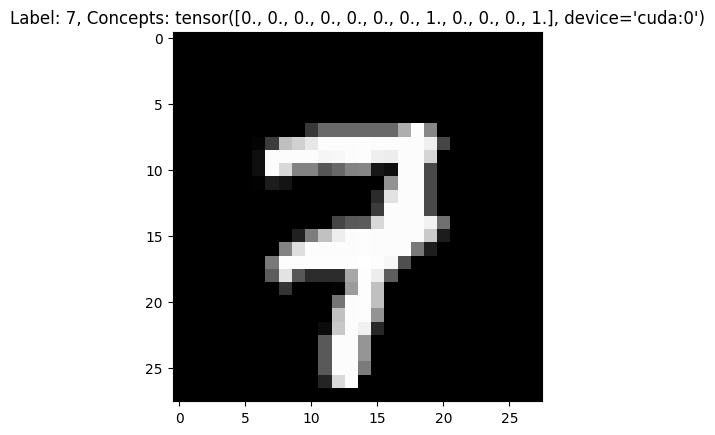

In [10]:
import matplotlib.pyplot as plt

for images, labels, concepts in train_loader:
    img_idx = 8
    image = images[img_idx]
    fig, ax = plt.subplots(1)
    ax.imshow(image.squeeze().cpu(), cmap="gray")
    plt.title(f"Label: {labels[img_idx].argmax()}, Concepts: {concepts[img_idx]}")
    plt.show()
    break

# Building the model

The model architecture is taken from the paper [1].

ConceptMNIST: The network g consists of 2 convolutional
layers with 32 channels each, along with a maxpool
layer in between followed by a fully connected
layer. The network f consists of a fully connected layer.

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class g(nn.Module):
    """The network g consists of 2 convolutional
    layers with 32 channels each, along with a maxpool
    layer in between followed by a fully connected
    layer."""

    def __init__(self):
        super(g, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 32, 3, 1)
        self.fc1 = nn.Linear(800, 128)
        self.fc2 = nn.Linear(128, 14)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        non_overlapping, overlapping1, overlapping2 = x[:,:10], x[:,10:12], x[:,12:]
        return non_overlapping, overlapping1, overlapping2

class f(nn.Module):
    def __init__(self) -> None:
        super(f, self).__init__()
        self.fc1 = nn.Linear(14, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

def split_concepts(concepts):
    return concepts[:,:10], concepts[:,10:]

# Sequential training

Sequential Training: Learns the concept model g by
minimizing the concept training loss and subsequently
learns the class prediction model f by minimizing the
classification loss independently. Mathematically it can
be thought of minimizing training objective detailed in
Equation 4 first with
= 0 and then subsequently minimizing
with  = 0. As concepts once learned are never
updated again during prediction model optimization, the
concepts learned are completely independent of the prediction
task.

## First we need to learn g

In [6]:
g_model = g().to(device)
optimizer = torch.optim.Adam(g_model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
epochs = 20

In [ ]:


def train_g(model, train_loader, epochs, optimizer, criterion):
    model.train()
    for epoch in range(epochs):
        for images, labels, concepts in train_loader:
            images, labels, concepts = images.to(device), labels.to(device), concepts.to(device)
            y_true_non_overlapping, y_true_overlapping = split_concepts(concepts)
            optimizer.zero_grad()

            non_overlapping, overlapping1, overlapping2 = model(images)
            # Calculate the loss for non_overlaaping concepts
            loss_non_overlapping = criterion(non_overlapping, y_true_non_overlapping.argmax(dim=1))
            # Calculate the loss for overlapping concepts
            loss_overlapping1 = criterion(overlapping1, y_true_overlapping[:,0].long())
            loss_overlapping2 = criterion(overlapping2, y_true_overlapping[:,1].long())
            # Calculate the total loss
            loss = loss_non_overlapping + loss_overlapping1 + loss_overlapping2
            loss.backward()
            optimizer.step()
        print(f"Epoch: {epoch+1}, Loss: {loss.item():.3f}")

train_g(g_model, train_loader, epochs, optimizer, criterion)

Epoch: 1, Loss: 0.695
Epoch: 2, Loss: 0.232
Epoch: 3, Loss: 0.088
Epoch: 4, Loss: 0.085
Epoch: 5, Loss: 0.158
Epoch: 6, Loss: 0.095
Epoch: 7, Loss: 0.155
Epoch: 8, Loss: 0.131
Epoch: 9, Loss: 0.044
Epoch: 10, Loss: 0.104
Epoch: 11, Loss: 0.133
Epoch: 12, Loss: 0.028
Epoch: 13, Loss: 0.012
Epoch: 14, Loss: 0.126
Epoch: 15, Loss: 0.037
Epoch: 16, Loss: 0.034
Epoch: 17, Loss: 0.022
Epoch: 18, Loss: 0.007
Epoch: 19, Loss: 0.023
Epoch: 20, Loss: 0.070


### Calculating Accuracy of the concept model

Non-Overlapping concepts

In [ ]:
def calc_acc_non_overlapping(model, test_loader):
    model.eval()
    accuracies = []
    for images, labels, concepts in test_loader:
        images, labels, concepts = images.to(device), labels.to(device), concepts.to(device)
        y_true_non_overlapping, _ = split_concepts(concepts)
        non_overlapping, _, _ = model(images)
        y_pred_non_overlapping = non_overlapping.argmax(dim=1)
        acc =  (y_pred_non_overlapping == y_true_non_overlapping.argmax(dim=1)).float().mean().item()
        accuracies.append(acc)
    return sum(accuracies)/len(accuracies)

def calc_acc_overlapping(model, test_loader):
    model.eval()
    accuracies = []
    for images, labels, concepts in test_loader:
        images, labels, concepts = images.to(device), labels.to(device), concepts.to(device)
        _, y_true_overlapping = split_concepts(concepts)
        _, overlapping1, overlapping2 = model(images)
        y_pred_overlapping1 = overlapping1.argmax(dim=1)
        y_pred_overlapping2 = overlapping2.argmax(dim=1)
        acc = ((y_pred_overlapping1 == y_true_overlapping[:,0]) & (y_pred_overlapping2 == y_true_overlapping[:,1])).float().mean().item()
        accuracies.append(acc)
    return sum(accuracies)/len(accuracies)

def calc_acc(model, test_loader):
    model.eval()
    accuracies = []
    for images, labels, concepts in test_loader:
        images, labels, concepts = images.to(device), labels.to(device), concepts.to(device)
        y_true_non_overlapping, y_true_overlapping = split_concepts(concepts)
        non_overlapping, overlapping1, overlapping2 = model(images)
        y_pred_non_overlapping = non_overlapping.argmax(dim=1)
        y_pred_overlapping1 = overlapping1.argmax(dim=1)
        y_pred_overlapping2 = overlapping2.argmax(dim=1)
        acc = ((y_pred_non_overlapping == y_true_non_overlapping.argmax(dim=1)) & (y_pred_overlapping1 == y_true_overlapping[:,0]) & (y_pred_overlapping2 == y_true_overlapping[:,1])).float().mean().item()
        accuracies.append(acc)
    return sum(accuracies)/len(accuracies)

In [ ]:
print(f"Accuracy for non-overlapping concepts: {calc_acc_non_overlapping(g_model, test_loader):.3f}")
print(f"Accuracy for overlapping concepts: {calc_acc_overlapping(g_model, test_loader):.3f}")
print(f"Accuracy for all concepts: {calc_acc(g_model, test_loader):.3f}")

Accuracy for non-overlapping concepts: 0.988
Accuracy for overlapping concepts: 0.988
Accuracy for all concepts: 0.982


In [ ]:
# # Saving the trained g_model
# torch.save(g_model.state_dict(), "./models/g_model2.pth")

In [12]:
# loading g_trained_model
g_model = g().to(device)
g_model.load_state_dict(torch.load("g_model1.pth"))

<All keys matched successfully>

## Then we learn f by using the learned g

In [ ]:
f_model = f().to(device)
optimizer = torch.optim.Adam(f_model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
epochs = 20

In [ ]:
def train_f(f_model, g_model, train_loader, optimizer, criterion, epochs):
    f_model.train()
    for epoch in range(epochs):
        for images, labels, _ in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            non_overlapping, overlapping1, overlapping2 = g_model(images)
            # Concatenate the concepts
            overlapping = torch.cat([non_overlapping, overlapping1, overlapping2], dim=1)
            y_pred = f_model(overlapping)
            loss = criterion(y_pred, labels.argmax(dim=1))
            loss.backward()
            optimizer.step()
        print(f"Epoch: {epoch+1}, Loss: {loss.item():.3f}")
train_f(f_model, g_model, train_loader, optimizer, criterion, epochs)

Epoch: 1, Loss: 0.223
Epoch: 2, Loss: 0.116
Epoch: 3, Loss: 0.067
Epoch: 4, Loss: 0.060
Epoch: 5, Loss: 0.010
Epoch: 6, Loss: 0.041
Epoch: 7, Loss: 0.007
Epoch: 8, Loss: 0.013
Epoch: 9, Loss: 0.012
Epoch: 10, Loss: 0.006
Epoch: 11, Loss: 0.014
Epoch: 12, Loss: 0.011
Epoch: 13, Loss: 0.021
Epoch: 14, Loss: 0.005
Epoch: 15, Loss: 0.025
Epoch: 16, Loss: 0.008
Epoch: 17, Loss: 0.002
Epoch: 18, Loss: 0.087
Epoch: 19, Loss: 0.112
Epoch: 20, Loss: 0.008


In [ ]:
def calc_acc_prediction(g_model, f_model, test_loader):
    accuracies = []
    for images, labels, _ in test_loader:
        images, labels = images.to(device), labels.to(device)
        non_overlapping, overlapping1, overlapping2 = g_model(images)
        overlapping = torch.cat([non_overlapping, overlapping1, overlapping2], dim=1)
        y_pred = f_model(overlapping)
        y_pred = y_pred.argmax(dim=1)
        acc = (y_pred == labels.argmax(dim=1)).float().mean().item()
        accuracies.append(acc)
    return sum(accuracies)/len(accuracies)

calc_acc_prediction(g_model, f_model, test_loader)

0.9875597133757962

In [ ]:
# # Saving the f_model
# torch.save(f_model.state_dict(), "./models/sequential model/f_model1.pth")

In [13]:
# loading f_trained_model
f_model = f().to(device)
f_model.load_state_dict(torch.load("f_model1.pth"))

<All keys matched successfully>

In [23]:
# Building a sequential training model class

class Sequential(nn.Module):
  def __init__(self, g_model, f_model):
    super(Sequential, self).__init__()
    self.g_model = g_model
    self.f_model = f_model

  def forward(self, x):
    concepts = self.g_model(x)
    non_overlapping, overlapping1, overlapping2 = self.g_model(x)
    # Concatenate the concepts
    overlapping = torch.cat([non_overlapping, overlapping1, overlapping2], dim=1)
    return self.f_model(overlapping)

In [25]:
def calc_acc_prediction(model, test_loader):
    accuracies = []
    for images, labels, _ in test_loader:
        images, labels = images.to(device), labels.to(device)
        y_pred = model(images)
        y_pred = y_pred.argmax(dim=1)
        acc = (y_pred == labels.argmax(dim=1)).float().mean().item()
        accuracies.append(acc)
    return sum(accuracies)/len(accuracies)

model = Sequential(g_model, f_model)
calc_acc_prediction(model, test_loader)

0.9872611464968153

# Joint training

Joint Training: Learns both concept and prediction
models (f and g) by minimizing both concept and classification
loss jointly in an end-to-end manner. Mathematically
it can be thought of minimizing the entire training
objective Equation 4 with appropriate values of
and .
As concepts and prediction task are learned jointly, concepts
learned are not independent of the prediction task
as there is some guidance of gradient directions from the
prediction part of the model f in the concept model g.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Joint(nn.Module):
    def __init__(self, g_model, f_model):
        super(Joint, self).__init__()
        self.g_model = g_model
        self.f_model = f_model

    def forward(self, x):
        non_overlapping, overlapping1, overlapping2 = self.g_model(x)
        overlapping = torch.cat([non_overlapping, overlapping1, overlapping2], dim=1)
        y_pred = self.f_model(overlapping)
        return y_pred, non_overlapping, overlapping1, overlapping2


In [ ]:
pred_loss_weight, concepts_loss_weight = 0.5, 1

In [ ]:
def calc_loss(y_pred, labels, non_overlapping, overlapping1, overlapping2, y_true_non_overlapping, y_true_overlapping, criterion, pred_loss_weight, concepts_loss_weight):

    # Calculate the loss for non_overlaaping concepts
    loss_non_overlapping = criterion(non_overlapping, y_true_non_overlapping.argmax(dim=1))
    # Calculate the loss for overlapping concepts
    loss_overlapping1 = criterion(overlapping1, y_true_overlapping[:,0].long())
    loss_overlapping2 = criterion(overlapping2, y_true_overlapping[:,1].long())
    # Calculate the loss for concepts
    concept_loss = loss_non_overlapping + loss_overlapping1 + loss_overlapping2

    # Calculate the loss for prediction
    pred_loss = criterion(y_pred, labels.argmax(dim=1))

    loss = pred_loss_weight * pred_loss + concepts_loss_weight * concept_loss
    return loss

def train_joint(model, train_loader, epochs, optimizer, criterion):
    model.train()
    for epoch in range(epochs):
        for images, labels, concepts in train_loader:
            images, labels, concepts = images.to(device), labels.to(device), concepts.to(device)
            optimizer.zero_grad()
            y_true_non_overlapping, y_true_overlapping = split_concepts(concepts)
            y_pred, non_overlapping, overlapping1, overlapping2 = model(images)
            loss = calc_loss(y_pred, labels, non_overlapping, overlapping1, overlapping2, y_true_non_overlapping, y_true_overlapping, criterion, 1, 1)
            loss.backward()
            optimizer.step()
        print(f"Epoch: {epoch+1}, Loss: {loss.item():.3f}")
g_model = g().to(device)
f_model = f().to(device)
joint_model = Joint(g_model, f_model).to(device)
optimizer = torch.optim.Adam(joint_model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
epochs = 20
train_joint(joint_model, train_loader, epochs, optimizer, criterion)


Epoch: 1, Loss: 0.936
Epoch: 2, Loss: 0.861
Epoch: 3, Loss: 0.300
Epoch: 4, Loss: 0.776
Epoch: 5, Loss: 0.180
Epoch: 6, Loss: 0.547
Epoch: 7, Loss: 0.173
Epoch: 8, Loss: 0.140
Epoch: 9, Loss: 0.341
Epoch: 10, Loss: 0.021
Epoch: 11, Loss: 0.080
Epoch: 12, Loss: 0.044
Epoch: 13, Loss: 0.754
Epoch: 14, Loss: 0.016
Epoch: 15, Loss: 0.408
Epoch: 16, Loss: 0.110
Epoch: 17, Loss: 0.115
Epoch: 18, Loss: 0.170
Epoch: 19, Loss: 0.029
Epoch: 20, Loss: 0.300


In [ ]:
# Saving the joint_model
# torch.save(joint_model.state_dict(), "./models/joint/joint_model1.pth")

In [ ]:
g_model = g().to(device)
f_model = f().to(device)
joint_model = Joint(g_model, f_model).to(device)
joint_model.load_state_dict(torch.load("joint_model1.pth"))

<All keys matched successfully>

In [ ]:
def test_joint(model, test_loader):
    model.eval()
    accuracies = []
    for images, labels, concepts in test_loader:
        images, labels, concepts = images.to(device), labels.to(device), concepts.to(device)
        y_pred, _, _, _ = model(images)
        acc = (y_pred.argmax(dim=1) == labels.argmax(dim=1)).float().mean().item()
        accuracies.append(acc)
    return sum(accuracies)/len(accuracies)
test_joint(joint_model, test_loader)

0.9868630573248408

# Targeted attacks

In [ ]:
def pgd_linf_targ(model, X, y, epsilon, alpha, num_iter, y_targ):
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        print(f"Running iteration {t}")
        yp, _, _, _ = model(X + delta)
        loss = 2*yp[:, y_targ].sum() - yp.sum()
        loss.backward()

        delta = delta + alpha * delta.grad.detach().sign()
        delta = delta.clamp(-epsilon, epsilon).detach().requires_grad_(True)

        # Clear gradients after updating delta
        if delta.grad is not None:
            delta.grad.zero_()
    return delta.detach()


for images, labels, concepts in test_loader:
    images, labels, concepts = images.to(device), labels.to(device), concepts.to(device)
    break
delta = pgd_linf_targ(joint_model, images, labels, epsilon=0.4, alpha=1e-2, num_iter=40, y_targ=2)
yp, _,_,_ = joint_model(images + delta)

Running iteration 0
Running iteration 1
Running iteration 2
Running iteration 3
Running iteration 4
Running iteration 5
Running iteration 6
Running iteration 7
Running iteration 8
Running iteration 9
Running iteration 10
Running iteration 11
Running iteration 12
Running iteration 13
Running iteration 14
Running iteration 15
Running iteration 16
Running iteration 17
Running iteration 18
Running iteration 19
Running iteration 20
Running iteration 21
Running iteration 22
Running iteration 23
Running iteration 24
Running iteration 25
Running iteration 26
Running iteration 27
Running iteration 28
Running iteration 29
Running iteration 30
Running iteration 31
Running iteration 32
Running iteration 33
Running iteration 34
Running iteration 35
Running iteration 36
Running iteration 37
Running iteration 38
Running iteration 39


In [ ]:
def pgd_linf_targ(model, data_loader, epsilon, alpha, num_iter, y_targ, example):
    """
      Training on the whole test set
    """
    delta = torch.zeros_like(example, requires_grad=True)
    for t in range(num_iter):
      print(f"Running iteration {t}")
      for X, y, concepts in data_loader:
        X, y, concepts = images.to(device), labels.to(device), concepts.to(device)
        yp, _, _, _ = model(X + delta)
        loss = 2*yp[:, y_targ].sum() - yp.sum()
        loss.backward()

        delta = delta + alpha * delta.grad.detach().sign()
        delta = delta.clamp(-epsilon, epsilon).detach().requires_grad_(True)

        # Clear gradients after updating delta
        if delta.grad is not None:
            delta.grad.zero_()
    return delta.detach()


for images, labels, concepts in test_loader:
    images, labels, concepts = images.to(device), labels.to(device), concepts.to(device)
    break
delta = pgd_linf_targ(joint_model, test_loader, epsilon=0.4, alpha=1e-2, num_iter=20, y_targ=2, example=images)
yp, _,_,_ = joint_model(images + delta)

Running iteration 0
Running iteration 1
Running iteration 2
Running iteration 3
Running iteration 4
Running iteration 5
Running iteration 6
Running iteration 7
Running iteration 8
Running iteration 9
Running iteration 10
Running iteration 11
Running iteration 12
Running iteration 13
Running iteration 14
Running iteration 15
Running iteration 16
Running iteration 17
Running iteration 18
Running iteration 19
Running iteration 20
Running iteration 21
Running iteration 22
Running iteration 23
Running iteration 24
Running iteration 25
Running iteration 26
Running iteration 27
Running iteration 28
Running iteration 29
Running iteration 30
Running iteration 31
Running iteration 32
Running iteration 33
Running iteration 34
Running iteration 35
Running iteration 36
Running iteration 37
Running iteration 38
Running iteration 39


In [ ]:
import matplotlib.pyplot as plt

def plot_images(X,y,yp,M,N):
    f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N,M*1.3))
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(1-X[i*N+j][0].cpu().numpy(), cmap="gray")
            title = ax[i][j].set_title("Pred: {}".format(yp[i*N+j]))
            plt.setp(title, color=('g' if yp[i*N+j] == y[i*N+j].argmax() else 'r'))
            ax[i][j].set_axis_off()
    plt.tight_layout()

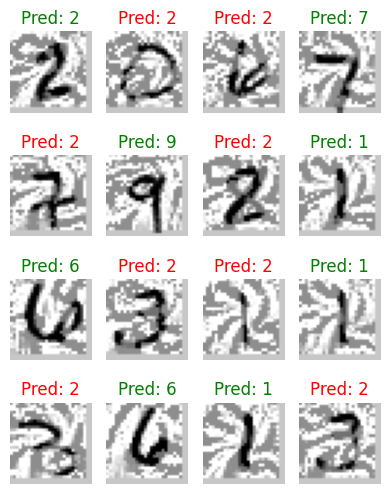

In [ ]:
plot_images(images+delta, labels, yp.argmax(dim=1), 4, 4)

In [ ]:
delta.shape

torch.Size([64, 1, 28, 28])

In [ ]:
def test_joint_addv(model, test_loader, delta):
    model.eval()
    accuracies = []
    for images, labels, concepts in test_loader:
        images, labels, concepts = images.to(device), labels.to(device), concepts.to(device)
        y_pred, _, _, _ = model(images + delta[:images.shape[0]])
        acc = (y_pred.argmax(dim=1) == labels.argmax(dim=1)).float().mean().item()
        accuracies.append(acc)
    return sum(accuracies)/len(accuracies)
test_joint_addv(joint_model, test_loader, delta)

0.2282046178343949

# Creating a standard CNN model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
  def __init__(self):
      super(CNN, self).__init__()
      self.conv1 = nn.Conv2d(1, 32, 3, 1)
      self.conv2 = nn.Conv2d(32, 32, 3, 1)
      self.fc1 = nn.Linear(800, 128)
      self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    return x



In [ ]:
cnn_model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=1e-4)
epochs = 20

In [ ]:
def train_cnn(model, train_loader, epochs, optimizer, criterion):
    model.train()
    for epoch in range(epochs):
        for images, labels, _ in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            y_pred = model(images)
            loss = criterion(y_pred, labels.argmax(dim=1))
            loss.backward()
            optimizer.step()
        print(f"Epoch: {epoch+1}, Loss: {loss.item():.3f}")

train_cnn(cnn_model, train_loader, epochs, optimizer, criterion)

Epoch: 1, Loss: 0.727
Epoch: 2, Loss: 0.057
Epoch: 3, Loss: 0.332
Epoch: 4, Loss: 0.093
Epoch: 5, Loss: 0.040
Epoch: 6, Loss: 0.029
Epoch: 7, Loss: 0.014
Epoch: 8, Loss: 0.040
Epoch: 9, Loss: 0.016
Epoch: 10, Loss: 0.015
Epoch: 11, Loss: 0.002
Epoch: 12, Loss: 0.018
Epoch: 13, Loss: 0.055
Epoch: 14, Loss: 0.008
Epoch: 15, Loss: 0.014
Epoch: 16, Loss: 0.005
Epoch: 17, Loss: 0.006
Epoch: 18, Loss: 0.017
Epoch: 19, Loss: 0.002
Epoch: 20, Loss: 0.008


In [ ]:
def test_cnn(model, test_loader):
  model.eval()
  accuracies = []
  for images, labels, _ in test_loader:
    images, labels = images.to(device), labels.to(device)
    y_pred = model(images).argmax(dim=1)
    acc = (y_pred == labels.argmax(dim=1)).float().mean().item()
    accuracies.append(acc)
  return sum(accuracies)/len(accuracies)
test_cnn(cnn_model, test_loader)

0.9884554140127388

# Target attacks on standard networks

In [ ]:
def pgd_linf_targ(model, data_loader, epsilon, alpha, num_iter, y_targ, example):
    delta = torch.zeros_like(example, requires_grad=True)
    for t in range(num_iter):
      print(f"Running iteration {t}")
      for X, y, concepts in data_loader:
        X, y, concepts = images.to(device), labels.to(device), concepts.to(device)
        yp = model(X + delta)
        loss = 2*yp[:, y_targ].sum() - yp.sum()
        loss.backward()

        delta = delta + alpha * delta.grad.detach().sign()
        delta = delta.clamp(-epsilon, epsilon).detach().requires_grad_(True)

        # Clear gradients after updating delta
        if delta.grad is not None:
            delta.grad.zero_()
    return delta.detach()


for images, labels, concepts in test_loader:
    images, labels, concepts = images.to(device), labels.to(device), concepts.to(device)
    break
delta = pgd_linf_targ(cnn_model, test_loader, epsilon=0.4, alpha=1e-2, num_iter=20, y_targ=2, example=images)

Running iteration 0
Running iteration 1
Running iteration 2
Running iteration 3
Running iteration 4
Running iteration 5
Running iteration 6
Running iteration 7
Running iteration 8
Running iteration 9
Running iteration 10
Running iteration 11
Running iteration 12
Running iteration 13
Running iteration 14
Running iteration 15
Running iteration 16
Running iteration 17
Running iteration 18
Running iteration 19


In [ ]:
def test_cnn_addv(model, test_loader, delta):
    model.eval()
    accuracies = []
    for images, labels, concepts in test_loader:
        images, labels, concepts = images.to(device), labels.to(device), concepts.to(device)
        y_pred = model(images + delta[:images.shape[0]])
        acc = (y_pred.argmax(dim=1) == labels.argmax(dim=1)).float().mean().item()
        accuracies.append(acc)
    return sum(accuracies)/len(accuracies)
test_cnn_addv(cnn_model, test_loader, delta)

0.1279856687898089

# References

[1] Understanding and Enhancing Robustness of Concept-based Models